# Use of PYBIND11_MAKE_OPAQUE

[pybind11](https://pybind11.readthedocs.io/) automatically converts `std::vector` into python list. That's convenient but not necessarily efficient depending on how it is used after that. [PYBIND11_MAKE_OPAQUE](https://pybind11.readthedocs.io/en/stable/advanced/cast/stl.html#making-opaque-types) is used to create a [capsule](https://docs.python.org/3/c-api/capsule.html) to hold a pointer on the C++ object.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Two identical classes

Both of then creates random vectors equivalent to `std::vector<Tensor>`, and `Tensor ~  std::vector<float>`. The first one returns a capsule due `PYBIND11_MAKE_OPAQUE(std::vector<OneTensorFloat>)` inserted into the C++ code. The other one is returning a list.

In [3]:
from cpyquickhelper.examples.vector_container_python import (
    RandomTensorVectorFloat, RandomTensorVectorFloat2)

rnd = RandomTensorVectorFloat(10, 10)
result = rnd.get_tensor_vector()
print(result)

In [4]:
result_ref = rnd.get_tensor_vector_ref()
print(result_ref)

In [5]:
rnd2 = RandomTensorVectorFloat2(10, 10)
result2 = rnd2.get_tensor_vector()
print(result2)

[<cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC4330>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC2BF0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC2E30>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC2C30>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC2FB0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC2970>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC26F0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC22B0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC21B0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000002B144BC20F0>]


In [6]:
result2_ref = rnd2.get_tensor_vector_ref()
print(result2_ref)

In [7]:
%timeit rnd.get_tensor_vector()

3.13 µs ± 60.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%timeit rnd.get_tensor_vector_ref()

1.21 µs ± 38.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%timeit rnd2.get_tensor_vector()

10.4 µs ± 138 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%timeit rnd2.get_tensor_vector_ref()

1.19 µs ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Scenarii

Three possibilities:

* **list**: `std::vector<Tensor>` is converted into a list of copied Tensors
* **capsule**: `std::vector<Tensor>` is converted into a capsule on a copied `std::vector<Tensor>`, the capsule still holds the pointer and is responsible to the deletion.
* **ref**: `std::vector<Tensor>` is just return as a pointer. The cost of getting the pointer does not depend on the content size. It is somehow the low limit.

## Plots

In [11]:
import itertools
from cpyquickhelper.numbers.speed_measure import measure_time
from tqdm import tqdm
import pandas

data = []
sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 5000, 10000]
sizes = list(itertools.product(sizes, sizes))
for i, j in tqdm(sizes):
    if j >= 1000:
        if i > 1000:
            continue
    if i * j >= 1e6:
        repeat, number = 3, 3
    else:
        repeat, number = 10, 10
    rnd = RandomTensorVectorFloat(i, j)
    obs = measure_time(lambda: rnd.get_tensor_vector(), repeat=repeat, number=number, div_by_number=True)
    obs['name'] = 'capsule'
    obs['n_vectors'] = i
    obs['size'] = j
    data.append(obs)

    rnd2 = RandomTensorVectorFloat2(i, j)
    obs = measure_time(lambda: rnd2.get_tensor_vector(), repeat=repeat, number=number, div_by_number=True)
    obs['name'] = 'list'
    obs['n_vectors'] = i
    obs['size'] = j
    data.append(obs)

    obs = measure_time(lambda: rnd2.get_tensor_vector_ref(), repeat=repeat, number=number, div_by_number=True)
    obs['name'] = 'ref'
    obs['n_vectors'] = i
    obs['size'] = j
    data.append(obs)
    
df = pandas.DataFrame(data)
df.tail()

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:19<00:00,  7.43it/s]


,average,deviation,min_exec,max_exec,repeat,number,ttime,context_size,name,n_vectors,size
409,0.018321,0.000367,0.018026,0.018838,3,3,0.054962,64,list,10000,200
410,0.000002,0.000001,0.000001,0.000004,3,3,0.000007,64,ref,10000,200
411,0.010974,0.000492,0.010512,0.011656,3,3,0.032923,64,capsule,10000,500
412,0.035484,0.000900,0.034286,0.036456,3,3,0.106451,64,list,10000,500
413,0.000003,0.000002,0.000001,0.000005,3,3,0.000008,64,ref,10000,500


In [12]:
piv = pandas.pivot_table(df, index=['n_vectors', 'size'], columns=['name'], values='average')
piv['ratio'] = piv['capsule'] / piv['list']
piv.tail()

name             capsule      list       ref     ratio
n_vectors size                                        
10000     20    0.001611  0.009616  0.000001  0.167512
          50    0.001892  0.010399  0.000001  0.181907
          100   0.002597  0.014054  0.000002  0.184789
          200   0.004847  0.018321  0.000002  0.264565
          500   0.010974  0.035484  0.000003  0.309278

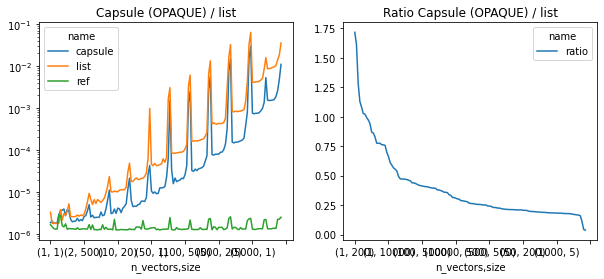

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv[['capsule', 'list', 'ref']].plot(logy=True, ax=ax[0], title='Capsule (OPAQUE) / list')
piv.sort_values('ratio', ascending=False)[['ratio']].plot(ax=ax[1], title='Ratio Capsule (OPAQUE) / list');

In [14]:
flat = piv.reset_index(drop=False)[['n_vectors', 'size', 'ratio']]
flat_piv = flat.pivot('n_vectors', 'size', 'ratio')
flat_piv

size,1,2,5,10,20,50,100,200,500,1000,5000,10000
n_vectors,,,,,,,,,,,,
1,0.566917,1.130723,0.995022,1.023320,1.028793,1.612390,0.943035,1.717130,1.284653,0.973898,1.083473,0.663566
2,0.862783,0.757669,0.775862,0.775123,0.829735,0.763393,0.776532,0.762319,0.871343,0.699622,0.612026,0.539308
5,0.379608,0.555293,0.368967,0.470159,0.378897,0.410572,0.589214,0.434686,0.395905,0.419958,0.461235,0.473515
10,0.301479,0.316046,0.374528,0.303198,0.407169,0.359681,0.288451,0.360526,0.402298,0.398315,0.393545,0.439519
20,0.356484,0.251247,0.230067,0.210293,0.252366,0.255456,0.288205,0.284486,0.252392,0.257864,0.416393,0.043764
50,0.231620,0.220888,0.210009,0.216061,0.214163,0.282138,0.266862,0.206823,0.263674,0.339590,0.039424,0.493669
100,0.394659,0.189204,0.256503,0.206615,0.214958,0.218592,0.240267,0.225569,0.243605,0.314168,0.412960,0.406809
200,0.201795,0.189723,0.211110,0.197427,0.212577,0.212658,0.212798,0.225500,0.257274,0.277588,0.439891,0.427631
500,0.189678,0.169699,0.188959,0.193446,0.184101,0.209909,0.205913,0.229271,0.243023,0.110660,0.472577,0.456907


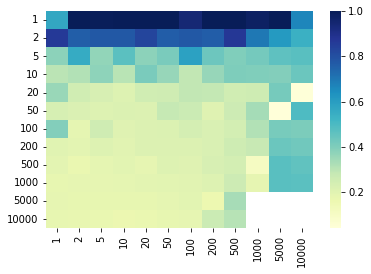

In [15]:
import numpy
import seaborn
seaborn.heatmap(numpy.minimum(flat_piv.values, 1), cmap="YlGnBu",
                xticklabels=list(flat_piv.index), yticklabels=list(flat_piv.columns));